In [1]:
import pandas as pd
import sys
import os.path as op 
from numpy.linalg import norm
from gensim.models import FastText
import numpy as np


basename = "/home/adrian/PhD/Tweet-Classification-Diabetes-Distress/"
path_utils = op.join(basename , "utils")
sys.path.insert(0, path_utils)

from sys_utils import load_library
from tweet_utils import tweet_vectorizer

from preprocess import Preprocess
prep = Preprocess()

        
def preprocess_tweet(tweet):
    tweet = prep.replace_contractions(tweet)
    tweet = prep.replace_hashtags_URL_USER(tweet, mode_URL="delete", mode_Mentions="delete")
    tweet = prep.remove_repeating_characters(tweet)
    tweet = prep.remove_repeating_words(tweet)
    tweet = prep.tokenize(tweet)
    tweet = prep.remove_punctuation(tweet)
    tweet = prep.to_lowercase(tweet)
    tweet = prep.remove_non_ascii(tweet)
    tweet = prep.replace_numbers(tweet)
    tweet = prep.remove_stopwords(tweet, include_personal_words=False, include_negations=False)
    tweet = [word for word in tweet if word not in ["diabetes", "diabetic"]]
    return tweet

def cosinus_similarity(a, b):
    return np.inner(a,b)/(norm(a)*norm(b))

model = FastText.load("/home/adrian/PhD/Data/FastText_embedding_20190703/ft_wordembeddings_dim300_minCount5_URL-User-toConstant_iter10_20190703")

data = pd.read_parquet("Tweets_groupLabel_20190715.parquet")
data["text_vec"] = data.text.map(lambda tweet: tweet_vectorizer(preprocess_tweet(tweet), model))

data.head()

[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/adrian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


no embedding for a8 !!!!!!!!!!!!
no embedding for a8 !!!!!!!!!!!!
no embedding for a8 !!!!!!!!!!!!


,id,text,user_name,gender,typeDiabetes,geo_adm1_code,geo_name,user_location,place_full_name,label,text_vec
0,1.129140e+18,When I was initially diagnosed with #type2diab...,Lynda Jimenez,1,1,AZ,Phoenix,"Phoenix, AZ",None,4,"[0.091667205, 0.032091808, -0.081855804, -0.07..."
1,1.102559e+18,Later Twitter it's back to sleep for a nap wok...,Deanna Porter Weick,0,0,MI,Monroe,"Monroe, MI",None,11,"[0.16888438, -0.029450605, 0.0862785, -0.06317..."
2,1.039046e+18,Ugh not ready for this 3hour glucose test tomo...,Esmeralda,2,0,CA,Hemet,Hemet CA,None,22,"[0.07679383, -0.038904045, 0.13049835, -0.2382..."
3,9.581800e+17,@hotfunkytown They also lock up diabetic suppl...,Joyce Pride,0,0,MO,Maryville,"Maryville, Missouri",None,3,"[0.12150481, 0.11272085, 0.11174324, -0.108990..."
4,9.151822e+17,@I_TheeWed “Hey mom! I know you’re dreading th...,Hot Mess Momma🍁,2,0,OK,Oklahoma City,Illinois ✈️ Oklahoma,None,3,"[0.06801716, 0.14217816, 0.018431958, -0.32431..."


In [2]:
def get_groupCenter(group, vectorColumn="text_vec"):
    matrix_form = np.asarray(group[vectorColumn].values.tolist())
    groupCenter = np.sum(matrix_form,axis=0) / matrix_form.shape[0]
    
    #group["cos_similarity_to_center"] = group["text_vec"].map(lambda vec: cosinus_similarity(vec, groupCenter))
    #group.sort_values(by="cos_similarity_to_center", ascending=False, inplace=True)
    #print(type(groupCenter), groupCenter.shape)
    return(groupCenter)


dataCenters = data.groupby(by="label", as_index=False) \
              .apply(lambda group: get_groupCenter(group, "text_vec")) \
              .reset_index(drop=True)

print(dataCenters.shape, type(dataCenters))

(30,) <class 'pandas.core.series.Series'>


In [3]:
data.shape

(46407, 11)

In [4]:

#cosine_sim_matrix = pd.DataFrame(columns=[topic_labels[i] for i in range(0,30)])#columns=["c0", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9",
#                                         "c10", "c11", "c12", "c13", "c14", "c15", "c16", "c17", "c18", "c19",
#                                         "c20", "c21", "c22", "c23", "c24", "c25", "c26", "c27", "c28", "c29"])

cosine_sim_matrix = np.zeros((data.shape[0], 30))
for i, row in data.iterrows():
    for j, center in enumerate(dataCenters):
        #print("i:", i, " j:", j)
        cosine_sim_matrix[i, j] = cosinus_similarity(row["text_vec"], center)
        
    if i % 5000 == 0 :
        print(i)

print(cosine_sim_matrix.shape)

0


/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


5000
10000
15000
20000
25000
30000
35000
40000
45000
(46407, 30)


In [162]:

topic_labels = {0:"DSMA_support_3", 1: "Diabetes_popstar_Nick_Jonas", 2:"Insulin_(access)", 3:"Negative_feelings_diabetes",
                4:"Diaversary", 5:"Misunderstandings_diabetes", 6:"Living_with_T1D", 7:"Access_insulin_insulinPrice",
                8:"Diagnosis", 9:"Inspire_relatives_living_with_diab_Support", 10:"insulin pump",
                11:"Inform_diab-rel_events_of_the_day", 12:"Bloodsugar_palette",
                13:"Inspire_relatives_living_with_diabetes", 14:"Glucose_guardian", 15:"T1D_hashtags",
                16:"DiabAwareness_Support_Donation", 17:"Glucosevariability", 18:"Diabetes_comorbidities",
                19:"Chronic_diseases_diab_comorbidities", 20:"DSMA_support_4", 21:"Confusion_between_T1D_and_T2D",
                22:"OGTT", 23:"DSMA_support_2", 24:"Diabetes_care", 25:"DSMA_support_1", 26:"Diabetes_and_entourage_1",
                27:"Life_with&without_diabetes", 28:"Diabetes_and_entourage_2", 29:"Insulin_use"}

topic_level1_labels = {
            0:"Diabetes online support", 1:"Miscellenous", 2:"Insulin", 3:"Feelings", 4:"Diabetes", 5:"Feelings", 
            6:"Life with diabetes", 7:"Insulin", 8:"Diabetes", 9:"Entourage", 10:"Insulin", 11:"Diabetes",
            12:"Miscellaneous", 13:"Entourage", 14:"Healthcare", 15:"Diabetes online support", 16:"Diabetes online support",
            17:"Diabetes", 18:"Diab-rel complications", 19:"Diab-rel complications",
            20:"Diabetes online support", 21:"Diabetes", 22:"OGTT", 23:"Diabetes online support",
            24:"Diabetes", 25:"Diabetes online support", 26:"Entourage", 27:"Life with diabetes",
            28:"Entourage", 29:"Insulin"}


#tuples = list(zip([topic_level1_labels[i] for i in range(0, 30)], [topic_labels[i] for i in range(0, 30)]))
#index = pd.MultiIndex.from_tuples(tuples, names=['Level1_topics', 'topics'])
#cosine_sim_matrix_pd = pd.DataFrame(cosine_sim_matrix, columns=index)
cosine_sim_matrix_pd = pd.DataFrame(cosine_sim_matrix, columns=[topic_labels[i] for i in range(0, 30)])
cosine_sim_matrix_pd.head()


,DSMA_support_3,Diabetes_popstar_Nick_Jonas,Insulin_(access),Negative_feelings_diabetes,Diaversary,Misunderstandings_diabetes,Living_with_T1D,Access_insulin_insulinPrice,Diagnosis,Inspire_relatives_living_with_diab_Support,...,DSMA_support_4,Confusion_between_T1D_and_T2D,OGTT,DSMA_support_2,Diabetes_care,DSMA_support_1,Diabetes_and_entourage_1,Life_with&without_diabetes,Diabetes_and_entourage_2,Insulin_use
0,0.791282,0.669108,0.722288,0.789422,0.897179,0.809238,0.784572,0.781562,0.875914,0.774045,...,0.798114,0.821806,0.705209,0.716898,0.777958,0.748924,0.786805,0.802394,0.823877,0.792698
1,0.777779,0.677034,0.714431,0.788249,0.788799,0.762542,0.766696,0.745560,0.766136,0.754690,...,0.823362,0.752624,0.772959,0.771036,0.757685,0.760285,0.749965,0.766812,0.804816,0.777757
2,0.725706,0.619255,0.644885,0.728903,0.691606,0.683046,0.727878,0.674981,0.673058,0.699553,...,0.746364,0.678024,0.910151,0.709898,0.684963,0.707004,0.673459,0.687651,0.699387,0.714653
3,0.780250,0.639622,0.778312,0.825264,0.741734,0.814218,0.798327,0.792016,0.745632,0.787514,...,0.814234,0.768517,0.696508,0.759176,0.794003,0.768892,0.749713,0.794803,0.780491,0.794746
4,0.826327,0.761986,0.760850,0.867632,0.811426,0.819195,0.799714,0.793929,0.811334,0.812940,...,0.853868,0.795667,0.854687,0.798708,0.781163,0.823555,0.784727,0.810683,0.838773,0.830035


In [7]:
"""
cosine_sim_matrix_pd.sort_values(by="Level1_topics", ascending=True, axis=1, inplace=True)
cosine_sim_matrix_pd.head()
"""

Level1_topics                  Diab-rel complications                         \
topics        Chronic_diseases_diabetes_comorbidities Diabetes_comorbidities   
0                                            0.754670               0.799564   
1                                            0.751750               0.780823   
2                                            0.653279               0.668633   
3                                            0.719558               0.772938   
4                                            0.751550               0.791156   

Level1_topics           Diabetes                           \
topics        Glucosevariability Diaversary Diabetes_care   
0                       0.787499   0.897179      0.777958   
1                       0.788522   0.788799      0.757685   
2                       0.781498   0.691606      0.684963   
3                       0.762014   0.741734      0.794003   
4                       0.839059   0.811426      0.781163   

Level1_topics                                                       \
topics        Information_diabetes-rel_events_of_the_day Diagnosis   
0                                               0.824847  0.875914   
1                                               0.834942  0.766136   
2                                               0.788727  0.673058   
3                                               0.776390  0.745632   
4                                               0.851447  0.811334   

Level1_topics                                \
topics        Confusion_between_T1D_and_T2D   
0                                  0.821806   
1                                  0.752624   
2                                  0.678024   
3                                  0.768517   
4                                  0.795667   

Level1_topics            Diabetes online support               ...  \
topics        DiabetesAwareness_Support_Donation T1D_hashtags  ...   
0                                       0.791326     0.633125  ...   
1                                       0.787132     0.644219  ...   
2                                       0.718917     0.633052  ...   
3                                       0.803927     0.695558  ...   
4                                       0.823605     0.668820  ...   

Level1_topics       Healthcare      Insulin                              \
topics        Glucose_guardian insulin pump Access_insulin_insulinPrice   
0                     0.609760     0.761099                    0.781562   
1                     0.673363     0.779850                    0.745560   
2                     0.797180     0.725273                    0.674981   
3                     0.644892     0.765765                    0.792016   
4                     0.786011     0.825038                    0.793929   

Level1_topics                              Life with diabetes  \
topics        Insulin_(access) Insulin_use    Living_with_T1D   
0                     0.722288    0.792698           0.784572   
1                     0.714431    0.777757           0.766696   
2                     0.644885    0.714653           0.727878   
3                     0.778312    0.794746           0.798327   
4                     0.760850    0.830035           0.799714   

Level1_topics                                 \
topics        Life_with_and_without_diabetes   
0                                   0.802394   
1                                   0.766812   
2                                   0.687651   
3                                   0.794803   
4                                   0.810683   

Level1_topics                        Miscellaneous  \
topics        Bloodsugar_palette_(beauty products)   
0                                         0.675697   
1                                         0.692485   
2                                         0.709737   
3                                         0.679626   
4                                         0.757357   

L

In [8]:
labels = [a+"__"+b for a, b in list(zip(corr.columns.get_level_values(level=0), corr.columns.get_level_values(level=1)))]
cosine_sim_matrix_pd.columns = labels
cosine_sim_matrix_pd.head()

NameError: name 'corr' is not defined

In [22]:

"""
cosine_sim_matrix_pd = cosine_sim_matrix_pd[[
"Entourage__Inspiring_relatives_living_with_diabetes",
"Entourage__Diabetes_and_entourage_2",
"Entourage__Diabetes_and_entourage_1",
"Entourage__Inspiring_relatives_living_with_diabetes_Support",
"Feelings__Misunderstandings_diabetes",
"Feelings__Negative_feelings_diabetes",
"Healthcare__Glucose_guardian",
"Life with diabetes__Living_with_T1D",
"Life with diabetes__Life_with_and_without_diabetes",
"Diab-rel complications__Chronic_diseases_diabetes_comorbidities",
"Diab-rel complications__Diabetes_comorbidities",
"Miscellaneous__Bloodsugar_palette_(beauty products)",
"Miscellenous__Diabetes_popstar_Nick_Jonas",
"Diabetes__Glucosevariability",
"Diabetes__Diaversary",
"Diabetes__Diabetes_care",
"Diabetes__Information_diabetes-rel_events_of_the_day",
"Diabetes__Diagnosis",
"Diabetes__Confusion_between_T1D_and_T2D",
"Insulin__insulin pump",
"Insulin__Access_insulin_insulinPrice",
"Insulin__Insulin_(access)",
"Insulin__Insulin_use",
"OGTT__OGTT",
"Diabetes online support__DiabetesAwareness_Support_Donation",
"Diabetes online support__DSMA_support_4",
"Diabetes online support__DSMA_support_3",
"Diabetes online support__DSMA_support_1",
"Diabetes online support__DSMA_support_2",
"Diabetes online support__T1D_hashtags"
]]
cosine_sim_matrix_pd.head()
"""

,Entourage__Inspiring_relatives_living_with_diabetes,Entourage__Diabetes_and_entourage_2,Entourage__Diabetes_and_entourage_1,Entourage__Inspiring_relatives_living_with_diabetes_Support,Feelings__Misunderstandings_diabetes,Feelings__Negative_feelings_diabetes,Healthcare__Glucose_guardian,Life with diabetes__Living_with_T1D,Life with diabetes__Life_with_and_without_diabetes,Diab-rel complications__Chronic_diseases_diabetes_comorbidities,...,Insulin__Access_insulin_insulinPrice,Insulin__Insulin_(access),Insulin__Insulin_use,OGTT__OGTT,Diabetes online support__DiabetesAwareness_Support_Donation,Diabetes online support__DSMA_support_4,Diabetes online support__DSMA_support_3,Diabetes online support__DSMA_support_1,Diabetes online support__DSMA_support_2,Diabetes online support__T1D_hashtags
0,0.726488,0.823877,0.786805,0.774045,0.809238,0.789422,0.609760,0.784572,0.802394,0.754670,...,0.781562,0.722288,0.792698,0.705209,0.791326,0.798114,0.791282,0.748924,0.716898,0.633125
1,0.762676,0.804816,0.749965,0.754690,0.762542,0.788249,0.673363,0.766696,0.766812,0.751750,...,0.745560,0.714431,0.777757,0.772959,0.787132,0.823362,0.777779,0.760285,0.771036,0.644219
2,0.705738,0.699387,0.673459,0.699553,0.683046,0.728903,0.797180,0.727878,0.687651,0.653279,...,0.674981,0.644885,0.714653,0.910151,0.718917,0.746364,0.725706,0.707004,0.709898,0.633052
3,0.726579,0.780491,0.749713,0.787514,0.814218,0.825264,0.644892,0.798327,0.794803,0.719558,...,0.792016,0.778312,0.794746,0.696508,0.803927,0.814234,0.780250,0.768892,0.759176,0.695558
4,0.788573,0.838773,0.784727,0.812940,0.819195,0.867632,0.786011,0.799714,0.810683,0.751550,...,0.793929,0.760850,0.830035,0.854687,0.823605,0.853868,0.826327,0.823555,0.798708,0.668820


In [16]:
corr = cosine_sim_matrix_pd.corr(method="spearman")
corr.head()

,DSMA_support_3,Diabetes_popstar_Nick_Jonas,Insulin_(access),Negative_feelings_diabetes,Diaversary,Misunderstandings_diabetes,Living_with_T1D,Access_insulin_insulinPrice,Diagnosis,Inspiring_relatives_living_with_diabetes_Support,...,DSMA_support_4,Confusion_between_T1D_and_T2D,OGTT,DSMA_support_2,Diabetes_care,DSMA_support_1,Diabetes_and_entourage_1,Life_with_and_without_diabetes,Diabetes_and_entourage_2,Insulin_use
DSMA_support_3,1.000000,0.712294,0.729400,0.920576,0.791880,0.920173,0.755010,0.696610,0.791068,0.832882,...,0.886479,0.882296,0.678533,0.719083,0.880774,0.912570,0.900449,0.912872,0.853223,0.800176
Diabetes_popstar_Nick_Jonas,0.712294,1.000000,0.622623,0.783413,0.772327,0.692462,0.645662,0.647990,0.802042,0.719628,...,0.863687,0.730648,0.527909,0.597894,0.666696,0.763074,0.747272,0.739162,0.860289,0.680328
Insulin_(access),0.729400,0.622623,1.000000,0.693736,0.596267,0.739565,0.771805,0.732402,0.600825,0.856642,...,0.736968,0.654357,0.388321,0.743695,0.746037,0.773272,0.709410,0.774449,0.651556,0.709402
Negative_feelings_diabetes,0.920576,0.783413,0.693736,1.000000,0.780115,0.929802,0.709453,0.730873,0.795823,0.763910,...,0.910260,0.872922,0.677319,0.655378,0.853822,0.880718,0.886213,0.912928,0.884878,0.826617
Diaversary,0.791880,0.772327,0.596267,0.780115,1.000000,0.785632,0.692458,0.720920,0.964027,0.705941,...,0.833371,0.886853,0.637129,0.548038,0.788008,0.766419,0.834550,0.803594,0.902185,0.750070


In [25]:
corr.to_csv("correlation_matrix_20190725.csv", sep=";", index_label=False, index=False)

In [26]:
aaa = pd.read_csv("correlation_matrix_20190725.csv", sep=";")
aaa.head()

,DSMA_support_3,Diabetes_popstar_Nick_Jonas,Insulin_(access),Negative_feelings_diabetes,Diaversary,Misunderstandings_diabetes,Living_with_T1D,Access_insulin_insulinPrice,Diagnosis,Inspiring_relatives_living_with_diabetes_Support,...,DSMA_support_4,Confusion_between_T1D_and_T2D,OGTT,DSMA_support_2,Diabetes_care,DSMA_support_1,Diabetes_and_entourage_1,Life_with_and_without_diabetes,Diabetes_and_entourage_2,Insulin_use
0,1.000000,0.712294,0.729400,0.920576,0.791880,0.920173,0.755010,0.696610,0.791068,0.832882,...,0.886479,0.882296,0.678533,0.719083,0.880774,0.912570,0.900449,0.912872,0.853223,0.800176
1,0.712294,1.000000,0.622623,0.783413,0.772327,0.692462,0.645662,0.647990,0.802042,0.719628,...,0.863687,0.730648,0.527909,0.597894,0.666696,0.763074,0.747272,0.739162,0.860289,0.680328
2,0.729400,0.622623,1.000000,0.693736,0.596267,0.739565,0.771805,0.732402,0.600825,0.856642,...,0.736968,0.654357,0.388321,0.743695,0.746037,0.773272,0.709410,0.774449,0.651556,0.709402
3,0.920576,0.783413,0.693736,1.000000,0.780115,0.929802,0.709453,0.730873,0.795823,0.763910,...,0.910260,0.872922,0.677319,0.655378,0.853822,0.880718,0.886213,0.912928,0.884878,0.826617
4,0.791880,0.772327,0.596267,0.780115,1.000000,0.785632,0.692458,0.720920,0.964027,0.705941,...,0.833371,0.886853,0.637129,0.548038,0.788008,0.766419,0.834550,0.803594,0.902185,0.750070


In [9]:
labels = [a+"__"+b for a, b in list(zip(corr.columns.get_level_values(level=0), corr.columns.get_level_values(level=1)))]
for label in labels:
    print(label)
#corr.columns = labels
#corr.index = labels
#corr.head()

Diab-rel complications__Chronic_diseases_diabetes_comorbidities
Diab-rel complications__Diabetes_comorbidities
Diabetes__Glucosevariability
Diabetes__Diaversary
Diabetes__Diabetes_care
Diabetes__Information_diabetes-rel_events_of_the_day
Diabetes__Diagnosis
Diabetes__Confusion_between_T1D_and_T2D
Diabetes online support__DiabetesAwareness_Support_Donation
Diabetes online support__T1D_hashtags
Diabetes online support__DSMA_support_4
Diabetes online support__DSMA_support_3
Diabetes online support__DSMA_support_1
Diabetes online support__DSMA_support_2
Entourage__Inspiring_relatives_living_with_diabetes
Entourage__Diabetes_and_entourage_2
Entourage__Diabetes_and_entourage_1
Entourage__Inspiring_relatives_living_with_diabetes_Support
Feelings__Misunderstandings_diabetes
Feelings__Negative_feelings_diabetes
Healthcare__Glucose_guardian
Insulin__insulin pump
Insulin__Access_insulin_insulinPrice
Insulin__Insulin_(access)
Insulin__Insulin_use
Life with diabetes__Living_with_T1D
Life with diabe

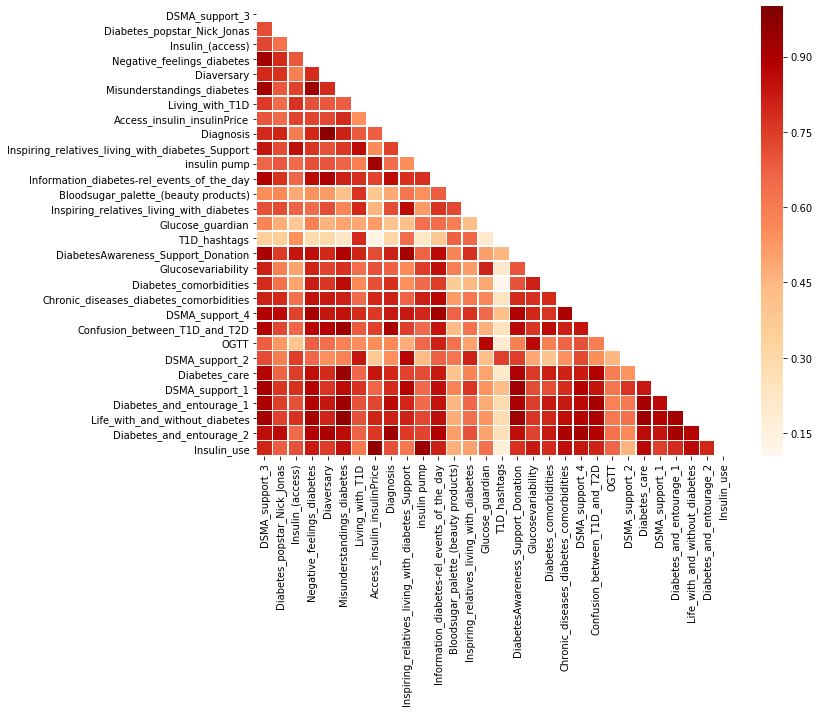

In [21]:
# Draw correlation plot
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,10))         # Sample figsize in inches

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
#f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#            square=True, linewidths=.5, cbar_kws={"shrink": .5})


#sns.heatmap(corr,  linewidths=.5, ax=ax, cmap="OrRd") #Reds
sns.heatmap(corr, mask=mask, linewidths=.5, ax=ax, cmap="OrRd") #Reds
#ax = sns.heatmap(corr, cmap="bwr")
plt.tight_layout()
plt.savefig("correlation_plot_20190723.png")

# 1) Change the color scale, dark blue to dark red is confusing because we can first think that dark blue means 
#    strong negative correlations and that it goes the opposite direction as the red ones, which is not the case,
#    so for the full non-filtered heatmap, can you please change this by going from white (corr=0) to red (corr=1), 
#    just like the plots filtered at 0.75, 0.8 etc...
#2) Change/shorten your labels and forget about mentioning the level 1 grouping, it is just very hard to read like 
#this. Just use the main label, not the one that we have used to group the topics.
#3) Plot only half of the matrix, either the upper part or bottom part, but not all the correlation matrix, as you
#have twice the same information.
#4) The vertical labels could be written diagonally to make the reading easier.



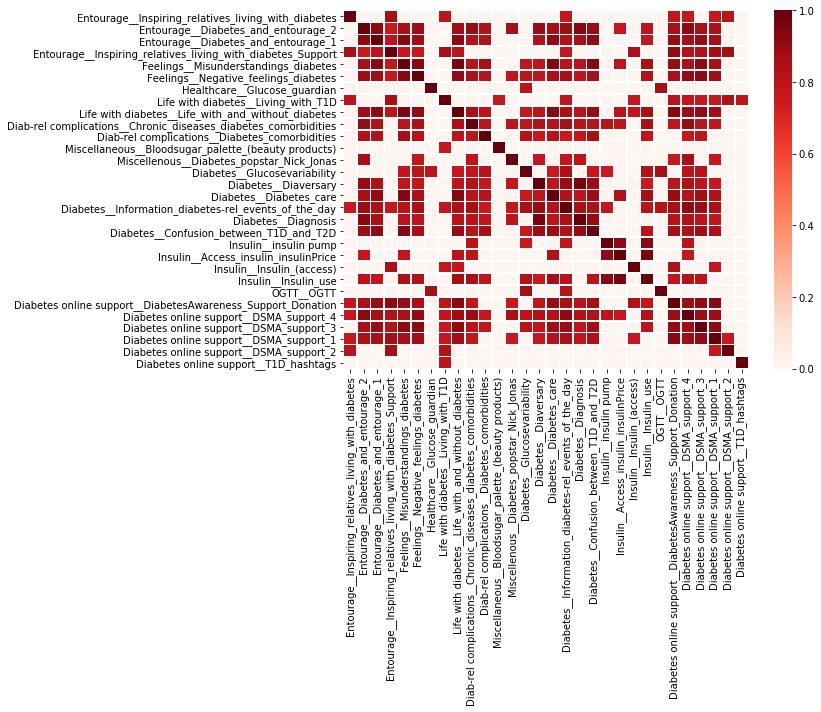

In [37]:
# Draw correlation plot
import seaborn as sns
import matplotlib.pyplot as plt

threshold = 0.75
mat = corr[corr > threshold].fillna(0)

fig, ax = plt.subplots(figsize=(12,10))         # Sample figsize in inches
sns.heatmap(mat,  linewidths=.5, ax=ax, cmap="Reds")
#ax = sns.heatmap(corr, cmap="bwr")
plt.tight_layout()
plt.savefig("correlation_plot_threshold_{}_20190723.png".format(threshold))

'\nAccent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, \nGnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r,\nPastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, \nPurples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, \nSet1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r,\nYlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, \nbwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag,\nflag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, \ngist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gn

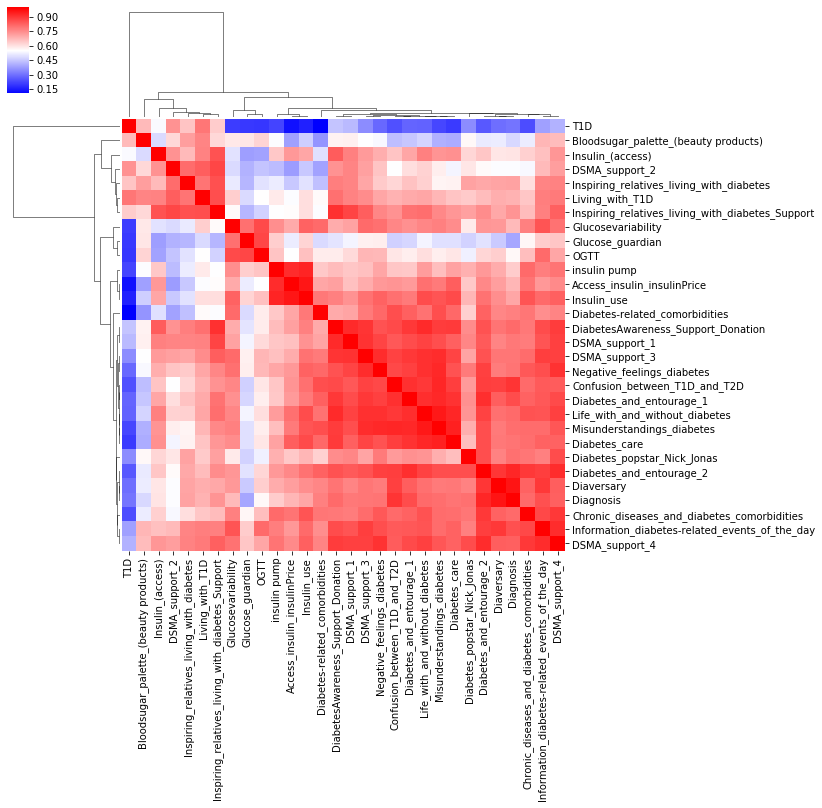

In [7]:
import seaborn as sns
%matplotlib inline
sns.clustermap(corr, metric="cosine", method='average', cmap="bwr") # coolwarm, inferno_r

"""
Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, 
GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r,
Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, 
Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, 
Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r,
YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, 
bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag,
flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, 
gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r,
gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma,
magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, 
prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10,
tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, 
twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r
"""

# Barplots

In [15]:
import pandas as pd
topic_labels = {0:"DSMA sharing diabetes-related anecdotes", 1: "Diabetes pop star Nick Jonas", 2:"Advocacy for affordable insulin", 3:"Negative feelings about diabetes",
                4:"Diaversary", 5:"Misunderstandings of diabetes", 6:"Life with type 1 diabetes", 7:"Frustration with insulin prices",
                8:"Diagnosis", 9:"Inspiring relatives living with diabetes", 10:"Insulin pump complications",
                11:"Day-to-day stories about diabetes", 12:"Bloodsugar palette (beauty prod.)",
                13:"Support/solidarity in diab. community", 14:"Glucose Guardian", 15:"T1D hashtags",
                16:"Diabetes awareness / Support / Donation", 17:"Glucose variability", 18:"Diabetes-related comorbidities",
                19:"Severe hypoglycemia", 20:"DSMA chatting about insulin", 21:"Confusion between T1D and T2D",
                22:"OGTT", 23:"DSMA enjoying online support", 24:"Diabetes care", 25:"DSMA sharing hope and cheering each other up", 26:"Diabetes in the family",
                27:"Life with and without diabetes", 28:"Parents and diabetes", 29:"Insulin"}



states = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

states_dict = {'Alaska': 'AK', 'Alabama': 'AL', 'Arkansas': 'AR', 'Arizona': 'AZ', 'California': 'CA', 
               'Colorado': 'CO', 'Connecticut': 'CT', 'District of Columbia': 'DC', 'Delaware': 'DE', 
               'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Iowa': 'IA', 'Idaho': 'ID', 'Illinois': 'IL',
               'Indiana': 'IN', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Massachusetts': 'MA',
               'Maryland': 'MD', 'Maine': 'ME', 'Michigan': 'MI', 'Minnesota': 'MN', 'Missouri': 'MO', 
               'Mississippi': 'MS', 'Montana': 'MT', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Nebraska': 'NE', 
               'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'Nevada': 'NV', 'New York': 'NY', 
               'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 
               'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 
               'Virginia': 'VA', 'Vermont': 'VT', 'Washington': 'WA', 'Wisconsin': 'WI', 'West Virginia': 'WV', 
               'Wyoming': 'WY'}

#sociofactors = pd.read_parquet("socioEconom_environmental_factors_20160718.parquet")
sociofactors = pd.read_parquet("/home/adrian/PhD/Data/SocioeconomicEnvironmentalFactors/Data_on_city_level/socioeconomifactors_cityLevel_20190731.parquet")
print(sociofactors.shape)

#sociofactors["region"] = sociofactors.region.map(lambda reg: reg[1::] if reg[0] == " " else reg)
sociofactors = sociofactors[sociofactors.region.isin(list(states_dict.keys()))] # take only US states (no puerto rico, virgin islands)

sociofactors["regionAbbr"] = sociofactors.region.map(lambda reg: states_dict[reg])

# get mean of socio factors per state (to replace missing values)
mean_socioFactors_perState = sociofactors[["Mean_income_(dollars)", "Median_age_years", "Sex_ratio_malesPer100females", 
              "Unemployment_rate_population16yearsAndOver", "Percent_bachelor's_degree_or_higher",
             "Gini_index", "Percent_Race_aloneOrCombinationWithOtherRaces_White", "regionAbbr"]].groupby(by="regionAbbr").mean()
print(mean_socioFactors_perState.index)


sociofactors = sociofactors[~sociofactors.city.str.contains("CDP")] # delete all cities with CDP to prevent wrong join
print(sociofactors.shape)



#sociofactors["geo_adm1_code"] = sociofactors["LocationAbbr"]

#del sociofactors["LocationAbbr"]
#print(sociofactors.shape)
#print(sociofactors.columns)

#sociofactors.head()


sociofactors.head(50)


(28407, 10)
Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
       'WI', 'WV', 'WY'],
      dtype='object', name='regionAbbr')
(19424, 11)


,Mean_income_(dollars),Median_age_years,Sex_ratio_malesPer100females,Total_population,Percent_bachelor's_degree_or_higher,Unemployment_rate_population16yearsAndOver,Gini_index,Percent_Race_aloneOrCombinationWithOtherRaces_White,region,city,regionAbbr
"Abbeville city, Alabama",56368,44.9,108.0,2594,13.4,6.6,0.5092,57.7,Alabama,Abbeville city,AL
"Adamsville city, Alabama",61459,42.7,89.3,4404,14.6,10.4,0.3955,48.0,Alabama,Adamsville city,AL
"Addison town, Alabama",47318,47.6,113.2,725,18.4,7.7,0.4386,99.6,Alabama,Addison town,AL
"Akron town, Alabama",23781,40.3,77.7,318,3.1,22.0,0.3644,22.0,Alabama,Akron town,AL
"Alabaster city, Alabama",84011,37.0,95.7,32567,34.8,4.4,0.3499,76.2,Alabama,Alabaster city,AL
"Albertville city, Alabama",53893,32.1,94.7,21342,12.8,3.1,0.4707,93.5,Alabama,Albertville city,AL
"Alexander City city, Alabama",47412,39.4,84.2,14705,15.5,11.6,0.4774,60.1,Alabama,Alexander City city,AL
"Aliceville city, Alabama",33573,36.3,90.4,2466,13.4,20.3,0.4924,23.7,Alabama,Aliceville city,AL
"Allgood town, Alabama",44204,33.2,120.4,606,2.8,2.4,0.3917,93.4,Alabama,Allgood town,AL
"Altoona town, Alabama",44193,40.5,88.8,861,7.3,0.0,0.4274,98.3,Alabama,Altoona town,AL


In [118]:

for i, row  in sociofactors.iterrows():
    #if "New York city" in row["city"]:
    if "Big Delta" in row["city"]:
    #if "Mass" in row["city"]:
        print(row["city"], ":: ", row["region"], ":: ", row["Total_population"])

"geo_adm1_code:geo_name"

#delete city or City

'geo_adm1_code:geo_name'

In [2]:
# adapt geo names in both tables for better matching
data["geo_name"] = data["geo_name"].map(lambda loc: loc.split(",")[0]) # Washington, D.C => Washington for easier matching between both dataframes
data["geo_name"] = data["geo_name"].map(lambda loc: loc.replace(" City", "").replace(" city","").replace(" town", "").replace(" village", ""))
sociofactors["city"] = sociofactors["city"].map(lambda loc: loc.replace(" City", "").replace(" city","").replace(" town", "").replace(" village", ""))
data["mergeColumn"] = data[["geo_adm1_code", "geo_name"]].apply(lambda x: '||'.join(x), axis=1)
sociofactors["mergeColumn"] = sociofactors[["regionAbbr", "city"]].apply(lambda x: '||'.join(x), axis=1)

NameError: name 'data' is not defined

In [166]:
joined = data.set_index("mergeColumn").join(sociofactors.set_index("mergeColumn"))
#joined = data.join(sociofactors.set_index('geo_adm1_code'), on="geo_adm1_code")
print(joined.shape)

# get indices of all entries where matching did not work and find them "manually"
indices_with_NaN = pd.isnull(joined[['Mean_income_(dollars)', 'Median_age_years',
                                     'Sex_ratio_malesPer100females', 'Total_population',
                                     "Percent_bachelor's_degree_or_higher",
                                     'Unemployment_rate_population16yearsAndOver', 'Gini_index',
                                     'Percent_Race_aloneOrCombinationWithOtherRaces_White', 'region',
                                    ]]).any(1).to_numpy().nonzero()[0]
print(len(indices_with_NaN))
print(indices_with_NaN)

c_nohits = 0
c_hits = 0
# merge manually the rows of the dataframes that did not match
for c, ind in enumerate(indices_with_NaN):
    row = joined.iloc[ind] 
    index_label = list(joined.index)[ind]
    
    # get all hits (rows) in the sociofactor table , where the geo_name in the tweets occurs is in the city name 
    hits = [(row_soc["city"], row_soc["region"], row_soc["Total_population"], 
             row_soc[["Mean_income_(dollars)", "Median_age_years", "Sex_ratio_malesPer100females", "Total_population",
              "Percent_bachelor's_degree_or_higher", "Unemployment_rate_population16yearsAndOver",
              "Gini_index", "Percent_Race_aloneOrCombinationWithOtherRaces_White"]]
            ) 
            for j, row_soc in sociofactors[sociofactors.regionAbbr == row["geo_adm1_code"]].iterrows() 
            if (row["geo_name"] in row_soc["city"])]

    # get hit with maximum number of population
    if len(hits) < 1:
        # if no hits found, replace values by mean
        mean_row = mean_socioFactors_perState.loc[row["geo_adm1_code"]]
        joined.at[index_label, "Mean_income_(dollars)"] = mean_row["Mean_income_(dollars)"]
        joined.at[index_label, "Median_age_years"] = mean_row["Median_age_years"]
        joined.at[index_label, "Sex_ratio_malesPer100females"] = mean_row["Sex_ratio_malesPer100females"]
        joined.at[index_label, "Percent_bachelor's_degree_or_higher"] = mean_row["Percent_bachelor's_degree_or_higher"]
        joined.at[index_label, "Unemployment_rate_population16yearsAndOver"] = mean_row["Unemployment_rate_population16yearsAndOver"]
        joined.at[index_label, "Gini_index"] = mean_row["Gini_index"]
        joined.at[index_label, "Percent_Race_aloneOrCombinationWithOtherRaces_White"] = mean_row["Percent_Race_aloneOrCombinationWithOtherRaces_White"]
        c_nohits += 1
    else:
        if len(hits) > 1: hit = max(hits, key=lambda item:item[2])
        elif len(hits) == 1: hit = hits[0]

        joined.at[index_label, "Mean_income_(dollars)"] = hit[3]["Mean_income_(dollars)"]
        joined.at[index_label, "Median_age_years"] = hit[3]["Median_age_years"]
        joined.at[index_label, "Sex_ratio_malesPer100females"] = hit[3]["Sex_ratio_malesPer100females"]
        joined.at[index_label, "Percent_bachelor's_degree_or_higher"] = hit[3]["Percent_bachelor's_degree_or_higher"]
        joined.at[index_label, "Unemployment_rate_population16yearsAndOver"] = hit[3]["Unemployment_rate_population16yearsAndOver"]
        joined.at[index_label, "Gini_index"] = hit[3]["Gini_index"]
        joined.at[index_label, "Percent_Race_aloneOrCombinationWithOtherRaces_White"] = hit[3]["Percent_Race_aloneOrCombinationWithOtherRaces_White"]
        c_hits += 1
    if c == 1000: print(c)

print("rows with no hits:", c_nohits)
print("rows with hits:", c_hits)
joined = joined.reset_index()
del joined["Total_population"]
del joined["region"]
del joined["city"]
del joined["regionAbbr"]

joined.head(100)

(46414, 22)
7087
[    0     1     2 ... 46401 46407 46412]
1000


,mergeColumn,id,text,user_name,gender,typeDiabetes,geo_adm1_code,geo_name,user_location,place_full_name,label,text_vec,Mean_income_(dollars),Median_age_years,Sex_ratio_malesPer100females,Percent_bachelor's_degree_or_higher,Unemployment_rate_population16yearsAndOver,Gini_index,Percent_Race_aloneOrCombinationWithOtherRaces_White
0,AK||Anchorage,9.645795e+17,Omg I just realized my #BloodSugar palette mig...,Amy Nalzy,1,0,AK,Anchorage,Alaska,None,12,"[0.14210594, 0.13130869, 0.124898545, -0.13243...",105010.0,33.1,104.4,34.6,5.8,0.4192,72.2
1,AK||Anchorage,9.281538e+17,"@AccessibleMeds Disgusting that, after all thi...",Pibble Lover,2,0,AK,Anchorage,Alaska,None,7,"[0.01542653, 0.0093314, 0.31082934, 0.02491086...",105010.0,33.1,104.4,34.6,5.8,0.4192,72.2
2,AK||Anchorage,1.138756e+18,@AtomicBlondeDJ Thanks. I found out how very i...,Chris Blankenship,0,2,AK,Anchorage,"Anchorage, AK",None,21,"[0.15055417, 0.08612734, -0.017736463, -0.1866...",105010.0,33.1,104.4,34.6,5.8,0.4192,72.2
3,AK||Anchorage,9.933439e+17,"Sometimes--okay, most of the time--I hate diab...",Zach Miller,0,0,AK,Anchorage,Alaska,None,3,"[0.14114456, 0.086271286, 0.043467637, -0.1354...",105010.0,33.1,104.4,34.6,5.8,0.4192,72.2
4,AK||Anchorage,1.134380e+18,@RepJayapal My landlord pays $500 dollars on i...,Jon Bauer,0,0,AK,Anchorage,Great State of Alaska,None,7,"[0.13130939, 0.044156834, 0.007035152, -0.0845...",105010.0,33.1,104.4,34.6,5.8,0.4192,72.2
5,AK||Anchorage,9.711092e+17,@Sir_Narwhal DAMN. I have to balance sugary st...,Zach Miller,0,0,AK,Anchorage,Alaska,None,29,"[0.15322828, 0.09139892, 0.112827435, -0.22139...",105010.0,33.1,104.4,34.6,5.8,0.4192,72.2
6,AK||Anchorage,8.863030e+17,Retweeted Kelly Hutchinson (@KickingWKelly): ...,Mark Kim Marion,0,2,AK,Anchorage,Alaska and Washington State,None,5,"[0.16189508, 0.24487996, -0.13318756, -0.17548...",105010.0,33.1,104.4,34.6,5.8,0.4192,72.2
7,AK||Anchorage,1.053003e+18,I woke up this morning with a swollen lower le...,NDNsec_,2,0,AK,Anchorage,Oregon-Alaska-Hawaii-Arizona,None,11,"[0.1078756, -0.16724333, -0.1513687, -0.150241...",105010.0,33.1,104.4,34.6,5.8,0.4192,72.2
8,AK||Anchorage,1.107763e+18,Was just getting ready for work and my package...,Safina Azlan,2,0,AK,Anchorage,"Anchorage, Alaska",None,12,"[0.15090172, 0.22084036, 0.07651864, -0.141507...",105010.0,33.1,104.4,34.6,5.8,0.4192,72.2
9,AK||Anchorage,1.087826e+18,this is the second glucose test I've had to do...,Brittny,1,0,AK,Anchorage,"Alaska, USA",None,22,"[0.018445859, -0.008965103, 0.050091766, -0.19...",105010.0,33.1,104.4,34.6,5.8,0.4192,72.2


In [230]:
del joined["text_vec"]
joined.to_parquet("tweets_sociofactors_joined_citylevel_20190801.parquet")

In [12]:
joined = pd.read_parquet("tweets_sociofactors_joined_citylevel_20190801.parquet")

In [6]:
#N = data.shape[0]
N = joined.shape[0]

#def get_low_medium_high(group):
def get_tertiles(dataColumn):
    tertile0 = dataColumn.min()
    tertile1, tertile2 = dataColumn.quantile([0.33, 0.66])
    tertile3 = dataColumn.max()
    return [tertile0, tertile1, tertile2, tertile3]


def get_probas_tertiles(data, topic, tertiles):
    probas = []
    for i in range(0, len(tertiles)):
        if i+1 < len(tertiles) - 1:
            temp = data[(data[topic] >= tertiles[i]) & (data[topic] < tertiles[i+1])]
            probas.append( temp.shape[0] / N)

        else:
            temp = data[(data[topic] >= tertiles[i]) & (data[topic] <= tertiles[i+1])]
            probas.append( temp.shape[0] / N)
            break

    return probas


def calculate_low_medium_high_overall(group, topic, tertiles, probas):
    overall = group.shape[0] / N
    probas_tertiles_per_group = get_probas_tertiles(group, topic, tertiles) # [P(topic_i & Factor in first tertile interval), P(topic_i & Factor in second tertile interval), P(topic_i & Factor in third tertile interval)]
    probas_conditional = [probas_tertiles_per_group[i] / probas[i] for i in range(0,len(probas))]

    return pd.DataFrame({"overall": overall, "low": probas_conditional[0], "med":probas_conditional[1], "high": probas_conditional[2]}, index=[topic_labels[group.label.values[0]]])


#topic = 'Estimate; Gini Index'
#topic = 'Mean income (dollars); Estimate; All households'
#topic = 'Unemployment-rate-Population-16-years-and-over__2017'
#topic = 'Percent_Two_or_more_races'
#topic = "Estimate_Median_age_years"
#topic = "Sex_ratio_(males_per_100_females)"
topic = "Mean_income_(dollars)"
#topic = "Median_age_years"
#topic = "Sex_ratio_malesPer100females"
#topic = "Percent_bachelor's_degree_or_higher"
#topic = "Unemployment_rate_population16yearsAndOver"
#topic = "Gini_index"
#topic = "Percent_Race_aloneOrCombinationWithOtherRaces_White"

tertiles = get_tertiles(joined[topic])
print("tertiles for factor:", tertiles)
probas_tertiles = get_probas_tertiles(joined, topic, tertiles)
print("probas_tertiles, P(factor = 1), P(factor = 2), P(factor = 3):", probas_tertiles)

temp = joined.groupby(by='label', as_index=False) \
            .apply(lambda group: calculate_low_medium_high_overall(group, topic, tertiles, probas_tertiles))# \
           # .reset_index(drop=True)
temp.index = [topic_labels[i] for i in range(0,30)]
temp.head(30)

for i in range(0, 30):
    group = joined[joined.label == i]
    groupdata = calculate_low_medium_high_overall(group, topic, tertiles, probas_tertiles)

tertiles for factor: [24609.0, 67224.0, 86758.0, 394259.0]
probas_tertiles, P(factor = 1), P(factor = 2), P(factor = 3): [0.3299650967380532, 0.30258111776619123, 0.3674537854957556]


In [16]:
from scipy.stats import chi2_contingency
from sklearn.feature_selection import chi2

N = joined.shape[0]
print("N total:", N)

#def get_low_medium_high(group):
def get_tertiles(dataColumn):
    tertile0 = dataColumn.min()
    tertile1, tertile2 = dataColumn.quantile([0.33, 0.66])
    tertile3 = dataColumn.max()
    return [tertile0, tertile1, tertile2, tertile3]


def get_probas_tertiles(data, topic, tertiles):
    #print("N-local:", data.shape[0])
    probas = []
    for i in range(0, len(tertiles)):
        if i+1 < len(tertiles) - 1:
            temp = data[(data[topic] >= tertiles[i]) & (data[topic] < tertiles[i+1])]
            probas.append( temp.shape[0] / N)
            #print("N_tweets probas tertiles:", temp.shape[0])
        else:
            temp = data[(data[topic] >= tertiles[i]) & (data[topic] <= tertiles[i+1])]
            probas.append( temp.shape[0] / N)
            #print("N_tweets probas tertiles:", temp.shape[0])            
            break

    return probas


def calculate_low_medium_high_overall(group, topic, tertiles, probas):
    
    overall = group.shape[0] / N
    probas_tertiles_per_group = get_probas_tertiles(group, topic, tertiles) # [P(topic_i & Factor in first tertile interval), P(topic_i & Factor in second tertile interval), P(topic_i & Factor in third tertile interval)]
    probas_conditional = [probas_tertiles_per_group[i] / probas[i] for i in range(0,len(probas))]
    #print("overall:", overall, "samples:", group.shape[0])
    #print("probas_tertiles_per_group:", probas_tertiles_per_group)
    #print("probas_conditional:", probas_conditional)
#    return pd.DataFrame({"overall": overall, "low": probas_conditional[0], "med":probas_conditional[1], "high": probas_conditional[2]}, index=[topic_labels[group.label.values[0]]])
    return pd.DataFrame({"low": probas_conditional[0], "med":probas_conditional[1], "high": probas_conditional[2]}, index=[topic_labels[group.label.values[0]]])


#topic = 'Estimate; Gini Index'
#topic = 'Mean income (dollars); Estimate; All households'
#topic = 'Unemployment-rate-Population-16-years-and-over__2017'
#topic = 'Percent_Two_or_more_races'
#topic = "Estimate_Median_age_years"
#topic = "Sex_ratio_(males_per_100_females)"
topic = "Mean_income_(dollars)"
#topic = "Median_age_years"
#topic = "Sex_ratio_malesPer100females"
#topic = "Percent_bachelor's_degree_or_higher"
#topic = "Unemployment_rate_population16yearsAndOver"
#topic = "Gini_index"
#topic = "Percent_Race_aloneOrCombinationWithOtherRaces_White"

tertiles = get_tertiles(joined[topic])
print("tertiles for factor:", tertiles)
#probas_tertiles = get_probas_tertiles(joined, topic, tertiles)
#print("probas_tertiles, P(factor = 1), P(factor = 2), P(factor = 3):", probas_tertiles)

def get_tertile_interval(factor, tertiles):
    if factor < tertiles[1]: return 1
    elif factor < tertiles[2] : return 2
    else: return 3


#data_to_plot = pd.DataFrame({}, columns=["overall", "low", "med", "high", "pvalue"])
data_to_plot = pd.DataFrame({}, columns=["low", "med", "high", "pvalue"])

for i in range(0, 30):
    
    # topic_i == 1
    joined["is_topic"] = joined.label.map(lambda label: 1 if label == i else 0)
    joined["factor_interval"] = joined[topic].map(lambda factor: get_tertile_interval(factor, tertiles))
    topic_true = joined[joined.label == i]
    topic_true_data = calculate_low_medium_high_overall(topic_true, topic, tertiles, probas_tertiles)

    stat, pvalue = chi2(joined["is_topic"].values.reshape(-1, 1), joined["factor_interval"])
    print("statistic chi2:", stat)
    print("pvalue:", pvalue[0])
    print
    topic_true_data["pvalue"] = pvalue
    data_to_plot = pd.concat([data_to_plot, topic_true_data])
    #break
#joined[["label", topic, "is_topic", "factor_interval"]].head(30)
data_to_plot.head(30)

N total: 46414
tertiles for factor: [24609.0, 67224.0, 86758.0, 394259.0]
statistic chi2: [0.45155205]
pvalue: 0.7978967896401892
statistic chi2: [5.10592248]
pvalue: 0.07785078926888629
statistic chi2: [63.05486918]
pvalue: 2.0314639958557437e-14
statistic chi2: [1.26242877]
pvalue: 0.5319454214105295
statistic chi2: [0.8721008]
pvalue: 0.6465851386954893
statistic chi2: [20.94568181]
pvalue: 2.8294562627601586e-05
statistic chi2: [12.48784549]
pvalue: 0.0019422217223241634
statistic chi2: [15.55589239]
pvalue: 0.0004188715724584899
statistic chi2: [0.33514362]
pvalue: 0.8457158845264596
statistic chi2: [29.24624794]
pvalue: 4.4592102757373764e-07
statistic chi2: [14.90924586]
pvalue: 0.0005787598530714855
statistic chi2: [23.65555884]
pvalue: 7.298954622449359e-06
statistic chi2: [29.65246678]
pvalue: 3.639558053970481e-07
statistic chi2: [1.59544661]
pvalue: 0.45035311390325816
statistic chi2: [0.21370418]
pvalue: 0.898658583600609
statistic chi2: [0.11277008]
pvalue: 0.945175137726

,low,med,high,pvalue
DSMA sharing diabetes-related anecdotes,0.031995,0.033395,0.032483,7.978968e-01
Diabetes pop star Nick Jonas,0.004962,0.003631,0.005336,7.785079e-02
Advocacy for affordable insulin,0.007117,0.008972,0.015831,2.031464e-14
Negative feelings about diabetes,0.045250,0.045500,0.043096,5.319454e-01
Diaversary,0.037414,0.035389,0.036060,6.465851e-01
Misunderstandings of diabetes,0.063663,0.068214,0.076869,2.829456e-05
Life with type 1 diabetes,0.030428,0.030333,0.036529,1.942222e-03
Frustration with insulin prices,0.057134,0.062589,0.068133,4.188716e-04
Diagnosis,0.021482,0.022216,0.022398,8.457159e-01
Inspiring relatives living with diabetes,0.029905,0.029977,0.039461,4.459210e-07


In [225]:
#temp.to_csv("/home/adrian/tmp/{}_probabilities.csv".format(topic), sep=";")

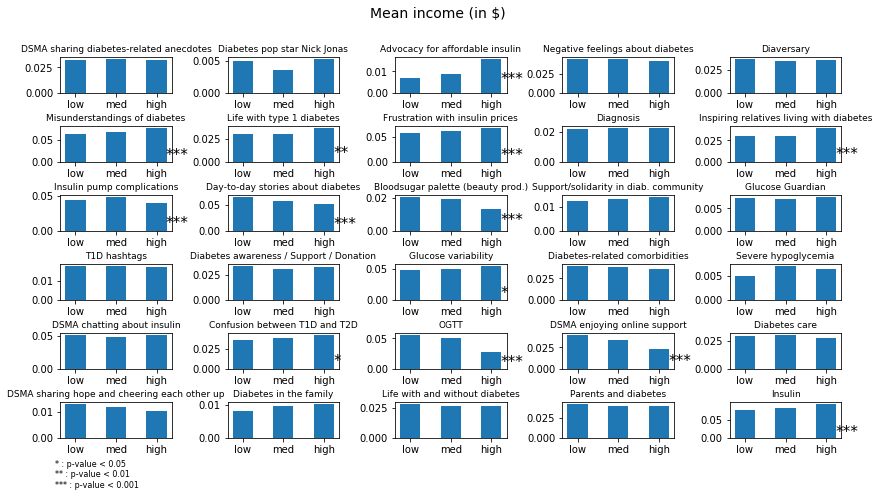

In [17]:
# Creates four polar axes, and accesses them through the returned array
import matplotlib.pyplot as plt

#%inline matplotlib
x = [1,2,3]
fig, axes = plt.subplots(6, 5, figsize=(14, 7))
plt.subplots_adjust(hspace=0.95, wspace=0.5)

row = 0
col = 0
for i in range(1,31):
    axes[row, col].bar(x, data_to_plot.iloc[i-1].values[0:3], tick_label=data_to_plot.columns[0:3], width=0.5)
#    axes[row, col].set_title(data_to_plot.iloc[i-1].name+"\n p={}".format(np.round(data_to_plot.iloc[i-1][-1], 4)), size=9)
    axes[row, col].set_title(data_to_plot.iloc[i-1].name, size=9)


    x_text = 3.23
    y_text = 0.004
    if data_to_plot.iloc[i-1][-1] < 0.001 : axes[row, col].text(x_text, y_text, '***', fontsize=15)
    elif data_to_plot.iloc[i-1][-1] < 0.01 : axes[row, col].text(x_text, y_text, '**', fontsize=15)
    elif data_to_plot.iloc[i-1][-1] < 0.05: axes[row, col].text(x_text, y_text, '*', fontsize=15)
        
    if i % 5 == 0 and i != 0:
        row += 1
        col = 0
    else:
        col += 1
        
plt.text(-16.0, -0.08, "* : p-value < 0.05", fontsize = 8)
plt.text(-16.0, -0.11, "** : p-value < 0.01", fontsize = 8)
plt.text(-16.0, -0.14, "*** : p-value < 0.001", fontsize = 8)
#fig.suptitle(topic, fontsize=14)
fig.suptitle("Mean income (in $)", fontsize=14)
plt.savefig("/home/adrian/tmp/{}_20190807.png".format(topic))
plt.show()